# 04 - Feature Engineering and Data Preprocessing
In this notebook we will prepare the data for the training of the model. To do so, we will build new features that have already been explored in the previous notebook and group the data. We will also separate the data set between train and test.

Steps:
1. Load data
2. Missing Values and Outliers
3. Build features
4. Aggregate flights
5. Store data for training

## Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [3]:
def add_days_until_dep_feature(df):
    """ Remaining days until flight departure """
    collected = pd.to_datetime(df['collectionDate'])
    departure =  pd.to_datetime(df['dDate'])
    daysUntilDep = departure - collected
    df['days_until_dep'] = daysUntilDep.dt.days
    return df

In [4]:
def split_data(df, test_days=30):
    """ Split data in train/test set """
    collection_dates = pd.to_datetime(df['collectionDate'])
    departure_dates = pd.to_datetime(df['dDate'])
    
    split_date = collection_dates.max() - timedelta(days=test_days)
    test_idx = (collection_dates >= split_date) & (departure_dates <= collection_dates.max())
    test = df[test_idx]
    train = df[~test_idx]
    return train, test

In [5]:
def q25(x):
    """ Return first quantile of x """
    return x.quantile(0.25)

In [6]:
def get_last_days_q25(row):
    """ Compute first quantile of last x days for each group """
    list_prices = row['list_prices']
    start_idx = row['days_until_dep']
    end_idx = start_idx+last_days

    last_days_prices = list_prices[start_idx:end_idx]
    if last_days_prices == []:
        last_days_prices = list_prices[-1]
    return np.quantile(last_days_prices, 0.25)

In [7]:
def get_labels(row):
    """ Assign wait or buy label """
    current_d = row['days_until_dep']
    current_price = row[combine_price_feature]
    list_prices = np.array(row['list_prices'])
    next_days = list_prices[:current_d-1]
    if len(next_days) == 0:
        return 0
    else:
        min_price = np.min(next_days)

        if min_price < current_price and 1-(min_price/current_price) > min_drop_per:
            return 1
        else:
            return 0

### Config var.



In [12]:
# feature to use to combine fare
combine_price_feature = 'customPrice'
# last days trend to compute customPrice and weight of this trend
last_days = 20
w = 0.7
# percentage of the minimum price drop to take into account to consider it worthwhile to wait
min_drop_per = 0.05 
# feature used for agg. flights
agg_cols = ['orig-dest', 'airline', 'session', 'days_until_dep']

## 1. Load data

In [8]:
df = pd.read_csv('../data/interim/flights_interim_small.csv')
df.shape

(1365075, 22)

## 2. Missing Values and Outliers

### Missing values

In [9]:
# remove seats because have many nan values and columns that we do not going to use
drop_cols = ['seats', 'dTimeUTC', 'aTimeUTC', 'flight_no',
            'cityFrom', 'cityCodeFrom', 'cityTo', 'cityCodeTo', 'countryFrom',
             'countryTo']
df.drop(drop_cols, axis=1, inplace=True);

### Outliers

In [10]:
Q1 = df['price'].quantile(.25)
Q3 = df['price'].quantile(.75)
IQR = Q3-Q1
# removing prices above IQR * 1.5
df = df[df['price'] < IQR*1.5 ]

## 3. Build features

Adding the features we have already explored in the previous notebook

In [11]:
# Adding new features

# orig and dest in same column
df['orig-dest'] = df['flyFrom']+'-'+df['flyTo']
# departure time in three categories: 'morning', 'evening', 'night'
df['session'] = pd.cut(pd.to_datetime(df['dTime']), bins=3, labels=['night', 'morning', 'evening'])
# Departure day of week
days_of_week = {5:'Monday', 6:'Tuesday', 0:'Wednesday', 1:'Thursday', 2:'Friday', 3:'Saturday', 4:'Sunday'}
df['day_of_week'] = pd.to_datetime(df['dTime']).dt.weekday.map(days_of_week)
# airline
df['airline'] = df['airlines'].apply(lambda x: x.split(',')[0])
# days until departure
df = add_days_until_dep_feature(df)

#df['groupID'] = df[agg_cols].agg('_'.join, axis=1)

## 3. Split data into train, valid and test

In [13]:
## Getting the last 30 days
train, test = split_data(df)

In [14]:
train.shape, test.shape

((903626, 17), (145502, 17))

In [15]:
valid_idx = test.sample(frac=.5, random_state=42).index

In [16]:
valid = test.loc[valid_idx].copy()
test = test.drop(valid_idx)

## 4. Aggregate flights

First, we will aggregate flights by some features.

In [35]:
%%time
# Grouping fligths by previously defined agg. cols. (orig-dest, airline, session, days_until_dep)
grouped = train \
            .groupby(agg_cols)[['price', 'fly_duration']] \
            .agg({'price':['min', 'median', q25, 'count'],
                  'fly_duration':'mean'}).dropna().reset_index()

# remove multilevel columns
grouped.columns = agg_cols + ['min', 'median', 'q25', 'count', 'fly_duration']

# count will act like some kind of competition factor
grouped.rename(columns={'count':'competition'}, inplace=True)

CPU times: user 23 s, sys: 99.4 ms, total: 23.1 s
Wall time: 23.2 s


Now we are going to add a new feature called 'customPrice' that will serve as a representation of the fare of each group taking into account the trend of the last few days. Finally we use this value to estimate to buy or wait for a price drop (labels)

customPrice = w * Total_q25 + (1-w)*(Last_days_q25)

In [37]:
# Feature 'total_q25': First quantile of each group during all time period
total_q25 = train.groupby(agg_cols)['price'].quantile(0.25) ######################### Revisar
total_q25 = total_q25.rename('total_q25').reset_index()
grouped['total_q25'] = pd.merge(grouped, total_q25, on=agg_cols, how='left')['total_q25']

In [38]:
# lastdays_q25: First quantile of last n days 
list_prices = grouped.groupby(['orig-dest','airline', 'session'])['q25'].agg(list)
list_prices = list_prices.reset_index()
list_prices.rename(columns={'q25':'list_prices'}, inplace=True)
grouped['list_prices'] = pd.merge(grouped, list_prices, on=['orig-dest','airline','session'], how='left')['list_prices']

In [39]:
grouped['lastdays_q25'] = grouped.progress_apply(get_last_days_q25, axis=1) 

100%|██████████| 36425/36425 [00:05<00:00, 6818.92it/s]


In [40]:
# CustomPrice = ticket price weightened considering last days trend
# We use this feature for estimate labels
grouped['customPrice'] =  w * grouped['total_q25'] + (1-w) * grouped['lastdays_q25']

In [41]:
# Wait/no wait labels
grouped['wait'] = grouped.progress_apply(get_labels, axis=1)

100%|██████████| 36425/36425 [00:02<00:00, 17112.77it/s]


In [42]:
grouped['wait'].value_counts()

1    20860
0    15565
Name: wait, dtype: int64

In [43]:
grouped.drop(['total_q25', 'list_prices', 'lastdays_q25'], axis=1, inplace=True, errors='ignore')

We will now use the new labels to estimate a new feature: the percentage of 'wait' labeled in each group.

In [44]:
probs = grouped.groupby(['orig-dest','session' ,'days_until_dep'])['wait'].mean().reset_index()
probs.rename(columns={'wait':'prob'}, inplace=True)
grouped = pd.merge(grouped, probs, on=['orig-dest', 'session' ,'days_until_dep'], how='left')

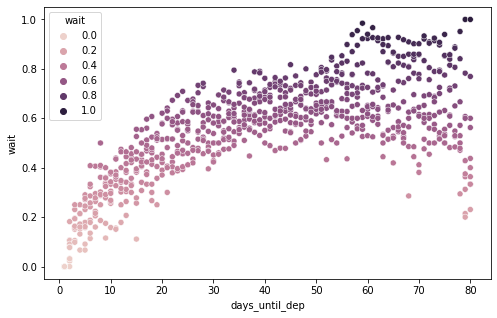

In [45]:
wait_grouped = grouped.groupby(['orig-dest','days_until_dep'])['wait'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.scatterplot(x='days_until_dep', y='wait', hue='wait', data=wait_grouped);

In [46]:
# final dataframe 
grouped.sample(5)

,orig-dest,airline,session,days_until_dep,min,median,q25,competition,fly_duration,customPrice,wait,prob
21276,MAD-JFK,AF,night,1,354.0,394.0,386.0,23,15.259420,336.78125,0,0.000000
3921,BCN-AMS,U2,evening,30,67.0,138.0,113.0,27,16.293210,102.42500,0,0.545455
28966,MAD-LHR,UX,morning,59,64.0,97.5,85.0,4,6.479167,76.90000,1,0.636364
10188,BCN-LGW,EW,evening,55,142.0,142.0,142.0,1,14.666667,186.02500,1,0.807692
34001,MAD-MEX,Y4,night,41,312.0,337.0,315.5,7,25.678571,309.70625,0,0.750000


#### Estimating days to wait and price drop percentage
In addition to predicting whether or not a flight will drop in price. We want to provide the user with an estimate of the **number of days to wait** and what the **percentage price drop** will be after that wait.
\
To do this we will create bins of 5 days for the values of 'days_until_dep', to each bin we will assign an estimated value. We will use these bins to look for the minimum price in the following days. The difference between the "current" bin and the next bin with the minimum price will be the expected price drop. 
\
For storing all this information we will create a new dataframe called 'price_bins'.

In [47]:
# Days to wait

# Creation of bins
lower = train['days_until_dep'].min()
higher = train['days_until_dep'].max()

n_bins = int(higher/5)
edges = range(lower, higher+5, 5)

lbs = ['(%d, %d]'%(edges[i], edges[i+1]) for i in range(len(edges)-1)]
train['days_bins'] = pd.cut(train['days_until_dep'],bins=n_bins, labels=lbs)

In [48]:
# create dataframe with bins and an estimate for the price 
price_bins = train.groupby(['orig-dest', 'airline', 'days_bins'])['price'].quantile(.25).rename('price_est').reset_index().dropna()

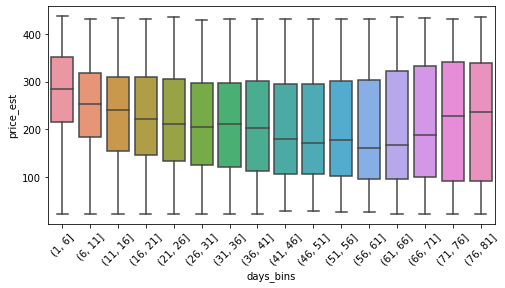

In [49]:
# plotting bins prices
plt.figure(figsize=(8,4))
sns.boxplot(x='days_bins', y='price_est', data=price_bins);
plt.xticks(rotation=45);

In [50]:
# adding bins edges. We will use this for compute days to wait
price_bins['bin_min'] = price_bins['days_bins'].astype('str').apply(lambda x: int(x.strip('(]').split(', ')[0])+1)
price_bins['bin_max'] = price_bins['days_bins'].astype('str').apply(lambda x: int(x.strip('(]').split(', ')[1]))

In [53]:
# final dataframe
price_bins.sample(5)

,orig-dest,airline,days_bins,price_est,bin_min,bin_max
12100,MAD-LHR,LG,"(21, 26]",284.0,22,26
11593,MAD-LHR,BA,"(46, 51]",84.0,47,51
7756,MAD-BCN,TP,"(61, 66]",70.0,62,66
2404,BCN-FCO,LG,"(21, 26]",170.5,22,26
4499,BCN-LGW,TO,"(16, 21]",179.0,17,21


In [54]:
bins_days = train[['days_until_dep', 'days_bins']].drop_duplicates()
bins_days['days_bins'] = bins_days['days_bins'].cat.codes

In [55]:
price_bins.to_csv('../data/processed/price_bins.csv', index=False)
bins_days.to_csv('../data/processed/bins_days.csv', index=False)

## 5. Save processed data

In [52]:
grouped.to_csv('../data/processed/train.csv', index=False)
valid.to_csv('../data/processed/valid.csv', index=False)
test.to_csv('../data/processed/test.csv', index=False)